Overview:
(some text regarding the purpose of this project, overall approach and a the hypothesis/qs)

Phase 1- 
Importing libraries and datasets

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
# import seaborn as sns

In [2]:
movie_gross = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
name_basics = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
title_akas = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
title_basics = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
#on inspection, we didn't find the following two datasets relevant to our hypotheses
#title_crew = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
#title_principals = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')
title_ratings = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
movie_info= pd.read_csv('./zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews= pd.read_csv('./zippedData/rt.reviews.tsv.gz', sep='\t', encoding='windows-1254')
budgets = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')



In [6]:
movie_info.genre

0                     Action and Adventure|Classics|Drama
1                       Drama|Science Fiction and Fantasy
2                       Drama|Musical and Performing Arts
3                              Drama|Mystery and Suspense
4                                           Drama|Romance
                              ...                        
1555     Action and Adventure|Horror|Mystery and Suspense
1556                   Comedy|Science Fiction and Fantasy
1557    Classics|Comedy|Drama|Musical and Performing Arts
1558      Comedy|Drama|Kids and Family|Sports and Fitness
1559    Action and Adventure|Art House and Internation...
Name: genre, Length: 1560, dtype: object

# print(movie_gross.isna().sum())
# print(name_basics.isna().sum())
# print(title_basics.isna().sum())
# print(title_akas.isna().sum())
# print(title_crew.isna().sum())
# print(title_principals.isna().sum())
# print(title_ratings.isna().sum())
# print(movie_info.isna().sum())
# print(budgets.isna().sum())

Phase 2-
Data cleaning, ordering and merging the datasets

In [21]:
#converting all values in budgets sheets to ints by removing commas and $
budgets['domestic_gross'] = budgets['domestic_gross'].astype(str)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$' , '')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',', '')
budgets['domestic_gross'] = budgets['domestic_gross'].astype(int)

budgets['production_budget'] = budgets['production_budget'].astype(str)
budgets['production_budget'] = budgets['production_budget'].str.replace('$' , '')
budgets['production_budget'] = budgets['production_budget'].str.replace(',', '')
budgets['production_budget'] = budgets['production_budget'].astype(int)

budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(str)
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$' , '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(',', '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(float)
#converting release dates to datetime format
budgets.release_date = pd.to_datetime(budgets['release_date'])
#adding a column in month format for easier graphing
budgets['release_month'] = budgets['release_date'].dt.strftime("%m%d")

In [22]:
#creating new lines showing the difference between gross and cost, aka net, as well as a profit percentage calculation showing net over budget
budgets['domestic_net']= budgets['domestic_gross']- budgets['production_budget']
budgets['worldwide_net']= budgets['worldwide_gross']- budgets['production_budget']
budgets['profit_percentage'] = (budgets['worldwide_net']/budgets['production_budget'])*100

In [23]:
#The movies in the budget sheet start in 1915 and will definitely pull the spread of our dataset way down, particularly as we measure revenue
budgets.release_date.sort_values().unique()
#dropping all values of movies made before 1995- this excludes about 700 rows with dates from 1915-1995 and leaves 5000
budgets = budgets[~budgets['release_date'].isin(pd.date_range(start='1915-01-01', end='1995-12-31'))]

In [24]:
#sorting the date columns for graphing so they run in chronological order. We'll need to either round the numbers to the tens place so they run either every ten days or figure out how to modify the bins/ticks on the graph in order to make things readable. Above I made two of the graphs absurdly large in order to read dates. Maybe we should rewrite the ticks to read as months (i.e. January, February) and leave the data the same? Could work at a 45 degree tilt instead of 90 but only works if we also figure out how to distribute the values by month. We could also set it as a range of months and try to get the datetime values to read accordingly- I've only just started messing with that. Visualizations aside, the next step is to establish correlations or trends in the data which I haven't even begun to test.
# sorted_budget_month = budgets['release_month'].sort_values()
# sorted_tomatoes_month = tomatoes.month.sort_values()
# this block is commented out for now as we find a better strategy for graphing by date

In [25]:
#combining ratings and basics to produce a dataframe that matches titles to ratings
titlerate = title_ratings.merge(title_basics, on= 'tconst', how= 'outer')
#dropping null values from the combined table
titlerate.dropna(subset= ['averagerating'], inplace = True)

In [26]:
titlerate.start_year.sort_values().unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int64)

In [48]:
titlerate.head()

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8.3,31.0,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,tt10384606,8.9,559.0,Borderless,Borderless,2019,87.0,Documentary
2,tt1042974,6.4,20.0,Just Inès,Just Inès,2010,90.0,Drama
3,tt1043726,4.2,50352.0,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy"
4,tt1060240,6.5,21.0,Até Onde?,Até Onde?,2011,73.0,"Mystery,Thriller"


In [27]:
#merging the two rotten tomatoes dataframes
tomatoes = rt_reviews.merge(movie_info, on='id', how='outer')

In [28]:
#changing the theater dates to datetime format so we can measure revenue against release date
tomatoes['theater_date'] = pd.to_datetime(tomatoes['theater_date'])
#dropping dates before 1995 in order to focus on relevant data
tomatoes= tomatoes[~tomatoes['theater_date'].isin(pd.date_range(start='1915-01-01', end='1995-12-31'))]
#dropping the date column to avoid confusion- it's the date of the review, whereas theater_date is the release
tomatoes.drop(['date'], axis = 1, inplace = True)
#reformatting the box office numbers to ints
tomatoes['box_office'] = tomatoes['box_office'].str.replace(',','')
#dropping null values here- it substantially cuts into our dataset and may not be the right choice, but I don't know how to switch to ints and leave null values. This column seems particularly valuable to map. Discuss?
tomatoes.dropna(subset= ['box_office'], inplace= True)
tomatoes['box_office'] = tomatoes['box_office'].astype(int)
#dropping null values from theater dates so we can graph dates against revenue later
tomatoes.dropna(subset= ['theater_date'], inplace= True)
#creating a date column that only contains day/month so we can identify trends based on time of year
tomatoes['month']= tomatoes['theater_date'].dt.strftime("%m/%d")

In [29]:
#since all currency seems to be in dollars we don't need to bother with a conversion here
tomatoes.currency.unique()

array(['$'], dtype=object)

Phase 3- 
Graphing and examining the datasets

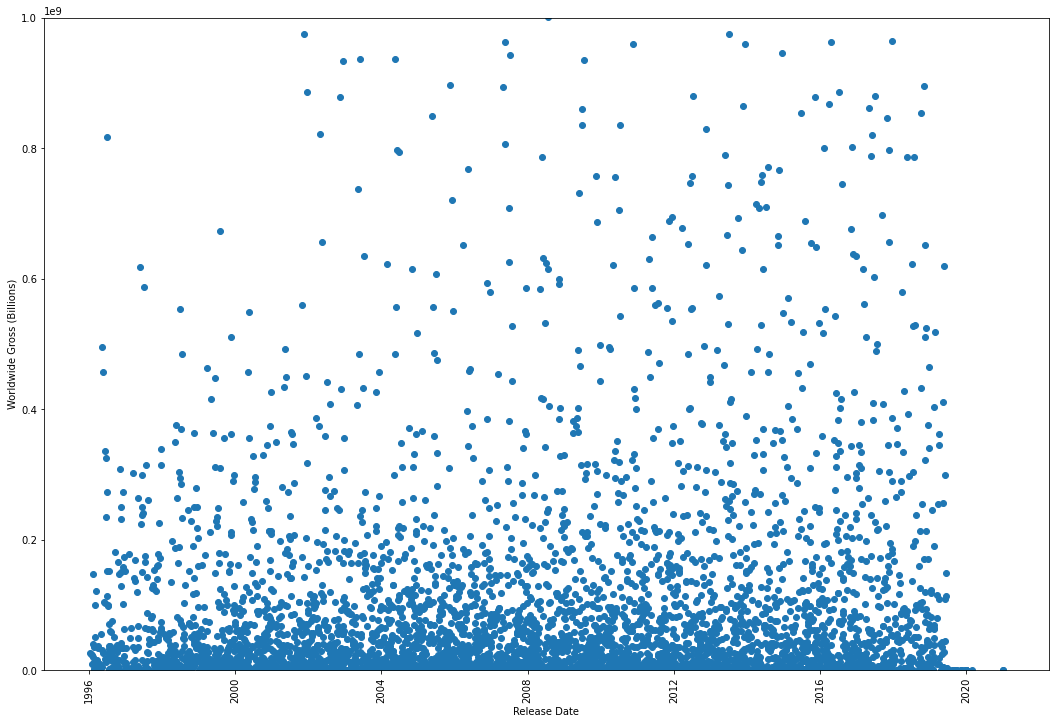

In [30]:
#this looks promising in terms of returning as usable conclusion
fig, ax = plt.subplots(figsize= (18, 12))
x= budgets.release_date
y= budgets.worldwide_gross 

ax.set_xlabel('Release Date')
ax.set_ylabel('Worldwide Gross (Billions)')
ax.set_ylim(0, 1000000000)
plt.xticks(rotation= 90)
plt.scatter(x, y)

In [37]:
tomatoes['fresh_index'] = tomatoes['fresh'].replace('fresh', 1).replace('rotten', 0)

In [38]:
tomatoes['fresh_average'] = tomatoes.groupby(['id'])['fresh_index'].mean()

In [39]:
#creating a new dataframe just using the fresh index average I created. This dataset is probably too small to be of use and we may need to do some webscraping to get more data and more accurate percentages.
tomatoes_fresh = tomatoes.dropna(subset= ['fresh_average'])

In [40]:
titlerate.dropna(subset= ['genres'], inplace=True)

<BarContainer object of 4925 artists>

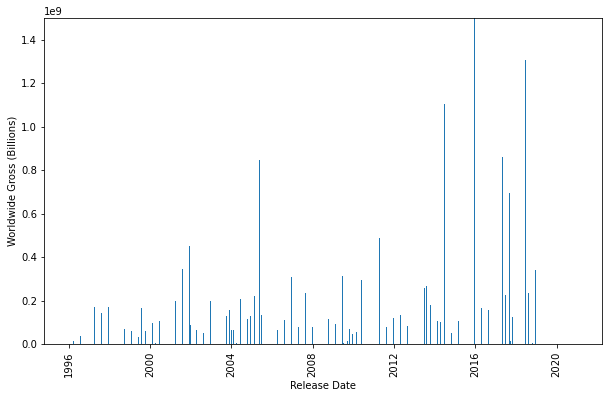

In [41]:
#plotting worldwide gross for our selected time period. There are some pretty obvious peaks and valleys, just need to get into the year over year and follow the trends. I cropped out the outlier data above $1.5bn to show more granular spread 
fig, ax = plt.subplots(figsize= (10, 6))
x= budgets['release_date']
y= budgets.worldwide_gross 

ax.set_xlabel('Release Date')
ax.set_ylabel('Worldwide Gross (Billions)')
ax.set_ylim(0, 1500000000)
plt.xticks(rotation= 90)
plt.bar(x, y)

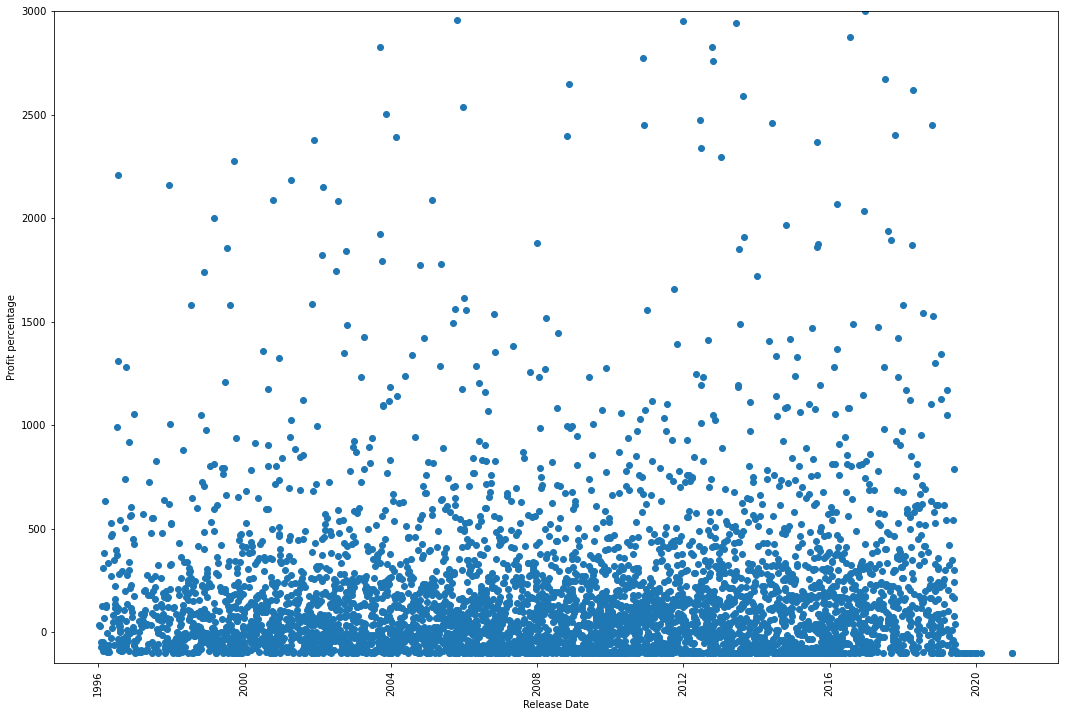

In [42]:
#a profitability scatter plot- note that I shifted the y limit to -150 to show loss. The top limit has a lot of outliers far beyond the top which flattened the graph if I didn't exclude them. This graph is a lot more difficult to interpret
fig, ax = plt.subplots(figsize= (18, 12))
x= budgets['release_date']
y= budgets.profit_percentage

ax.set_xlabel('Release Date')
ax.set_ylabel('Profit percentage')
plt.xticks(rotation= 90)
ax.set_ylim(-150, 3000)
plt.scatter(x, y)

In [ ]:
#here we see there is no correlation between initial production budget and profitability, which I think is our first noteworthy finding
budgets.corrwith(budgets['production_budget'])

In [ ]:
movie_gross.year.sort_values().unique()

In [21]:
movie_info['genres']=movie_info.genre.apply(lambda x: re.split("and|\|",x) if isinstance(x,str) else x)